<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/Owen_Unit6NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

# Unit 6: Multiple Generalized Linear Modeling

Last unit we learned how to predict a probalistic process using a different probablistic process--like using temperature to predict bike rentals.

This unit, we'll see what happens when we allow ourselves to use multiple predictors, instead of just one. This is more powerful, but also more challenging; we'll now have to decide what and how many predictors to use. We'll learn some new techniques and concepts to help us choose predictors and whole models, and we'll even use new libraries, bambi and kulprit, to make the model creation and checking process faster and more streamlined.

In the midst of all that, we'll introduce and dicuss the Under/Overfitting issue, which is the constant balancing act in modeling.

We'll also play with categorical variables, heirarchies, and introduce interactions. These are all ways to discover the relationship between different predictors.

Here's what we'll cover, and the order we'll cover it in:
1. Multiple Linear Regression with pymc and model comparison
2. Regression with Bambi
3. Balancing Underfitting with Overfitting
  - Variable selection (possibly with kulprit)
5. Distributional models (varable variance
6. Categorical variables versus Hierarchies
7. Interactions

Let's dive in.

We'll spend most of this unit with the bikes data set, so that we can focus on the new concepts. I'll then throw in examples with other data sets once we've introduced all the new things

In [7]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

In [8]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


## Multiple Linear Modeling with PyMC + Model Comparison with LOO

We will only use base PyMC for multiple linear modeling briefly. This is because multiple linear regression requires more plotting than simple linear regression, and bambi has some nice features for quickly and easily generating those plots.

We will use this oppurtunity to inroduce a new way to compare the performance of models: elpd_loo. This new method gives us a nice one number summary of which model is better, which is a useful tool to have when our models get two multidimensional to easily parse.

You've already seen the bikes model with temperature predicting rented. The model below is almost exactly the same.

In [4]:
#nbb stands for negative binomial bike model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_nbb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [5]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

The model below is almost exactly the same.

In [6]:
#mlb stands for multiple linear bikes
with pm.Model() as model_mlb:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)

    #linear part of the model
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.hour))

    #prior for the standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_mlb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [7]:
pm.sample_posterior_predictive(idata_mlb, model = model_mlb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

**Task1**:

Looking only at the code, what's the difference between model\_nbb and model\_mlb?

**Answer1**:

model_mlb has an extra normal prior to allow for another variable to be incorperated into the model. This effectively adds another slope to the model, creating a 3 dimensional line rather than two dimensional like before.

Let's compare the two models' preformance using a ppc

<Axes: xlabel='y'>

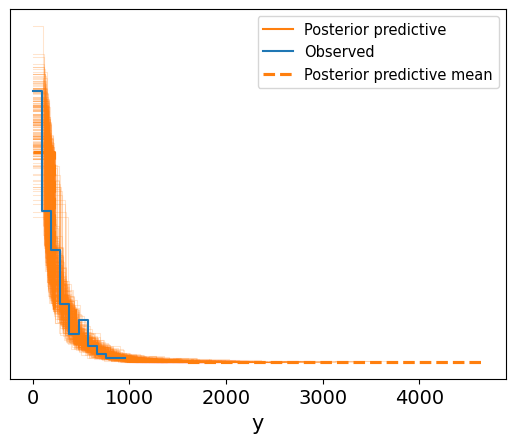

In [8]:
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

<Axes: xlabel='y'>

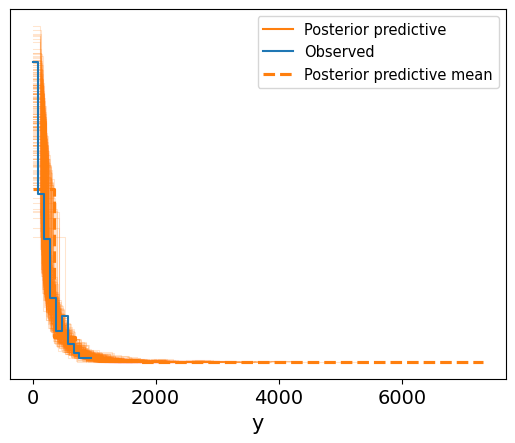

In [9]:
az.plot_ppc(idata_mlb, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task2**:

Describe any differences you can see.

**Answer2**:

The ppc's look basically identical. The second one goes further out on the x axis, but other than that they're the same.

Hopefully you're wondering if there is another way to compare these two models.

And there is!

The method is called Pareto Smoothed Importance Sampling Leave-One-Out Cross-Validation, which estimates the Expected Log-Pointwise-predictive Density.

We abbreviate all that with ELPD$_{LOO-CV}$, or elpd_loo, or even just LOO.

As the long full name implies, there are a lot of advanced, fancy tricks applied to the posterior to calculate LOO.

The important things to know:
- a more positive elpd_loo is better, but only in comparison to another model.
- the standard error (SE), sorta like the standard deviation, of elpd_loo helps tell us whether two models are significantly different than one another in terms of performance.
- There's something called a Pareto k diagnostic that tells us whether there were too many influential points for elpd_loo to be effective.



Let's look at the k diagnostic for the multiple linear model.

In [10]:
az.loo(idata_mlb)

,0
elpd_loo,-2124.301306
se,23.364747
p_loo,4.583698
n_samples,2000
n_data_points,348
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


All 348 values in the bikes data set have a small enough influence that we can almost completely trust elpd_loo's recommendation.

We also get the value of elpd_loo, and its standard error. But these are useless without another model to compare them too.

We do have another model to compare though! And arviz has some nice functions that will make the comparison trivial.

In [11]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"multi_lin":idata_mlb,"single_lin":idata_nbb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2124.301306,4.583698,0.000000,0.906259,23.364747,0.000000,False,log
single_lin,1,-2153.129351,2.700182,28.828046,0.093741,19.807261,8.165077,False,log


elpd_loo and se are easier to understand using the graph below.

The other relevant entries are warning, which just needs to say False--False means our k diagnostic was good enough. The other interesting entry is weight. This can be used to average the models being compared, using the following code:

```
idata_w = az.weight_predictions([idata_mlb,idata_nbb], weights=[0.903435, 0.096565])
```



Let's say we don't want to combine the models though, but choose between them. Then its often easier to graph the above table, then make a decision.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

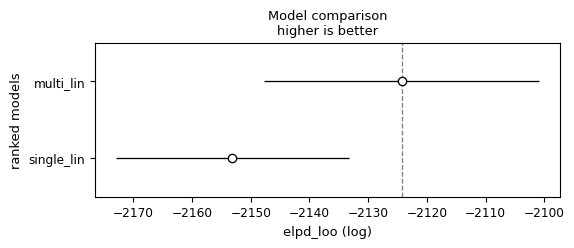

In [12]:
az.plot_compare(cmp_df)

**Task3**:

Using the model comparion table, which model would you pick? Why?

**Answer3**:

I would pick the multi linear model, but there isn't too much of a difference between the two.

## Bambi is Best
For (generalized) linear models, anyway.

Bambi is library for building bayesian (generalized) linear models.

Here are the two main two reasons to love bambi:

- by auto assigning normal and half normal priors with mean 0 and sd 1, bambi models are fast to write and read.
- it has built in methods for plotting the posterior means and posterior predictive distribution. No more giant blocks of code to create plots for linear models!

Here are the two main reasons to be cautious with bambi:

- it only works with (generalized) linear models. As in, using bambi means that we are assuming some type of linear model.
- bambi auto assigns normal and half normal priors with a mean of 0 and sd of 1. This isn't that big a deal, since there's a quick way to feed the priors we want into bambi. Its easy to get lazy with bambi, which is fine, until it isn't.

Colab also doesn't have bambi preinstalled, so we need to install it each time we pull up colab.

We will also need to install the latest version of xarray, since bambi relies on its latest features.

Note that you may get prompted to restart the session, especially if you've already run pymc and/or arviz. Go ahead and do so, if prompted.

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-1devk0s_
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-1devk0s_
  Resolved https://github.com/pydata/xarray.git to commit ceb5364be999567d08ba9be832fa0440e6dd3407
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.1-py3-none-any.whl size=1241687 sha256=36c6435944ed946482ed113bbe2bb8818ed0c43bce3618ecb8828eb8ed9ec751
  Stored in directory: /tmp/pip-ephem-wheel-cache-kp8hxhww/wheels/3a/ec/c0/1cda725917279b6beba2a020d6ccddfee2176b25648f4fcad8
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.0
    Uninstalling xarray-2025.1.0:
      Successfully uninstalled xarray-2025.1.0


In [2]:
import xarray as xr

In [3]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.2 MB/s eta 0:00:00


In [4]:
import bambi as bmb

In [5]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

### Linear Bikes + Regularizing Priors

Let's start by remaking the two bike models from earlier in the unit, but with bambi.

We'll also discuss the concept of regularizing priors; specifically, we'll see the the weakly informative priors bambi defaults too oftenn work great in practice.

#### Bambi bikes (1 predictor)
We'll start with the single variable model.

In [9]:
#we put the priors that aren't normal or half normal with mean 0 and sigma 1
#in a dict
priors ={"temperature" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_nbb_bmb = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial", priors=priors)

In [10]:
model_nbb_bmb

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            temperature ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfNormal(sigma: 10.0)

The 'family' argument in bmb.Model() is what determines both our likelihood and our link function. Bambi has default link functions that work well with families of likelihoods. Note the mu = log(x) is the same as exp(mu)=x.

Specifying 'family' is optional; the default is a normal likelihood.

Also notice that defining the model only takes two lines of code, and we only need one more to make the model it self.

In [11]:
#this is bambi's equivalent of pm.sample()
idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

Two more lines gives us a plot of the posterior mean.

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


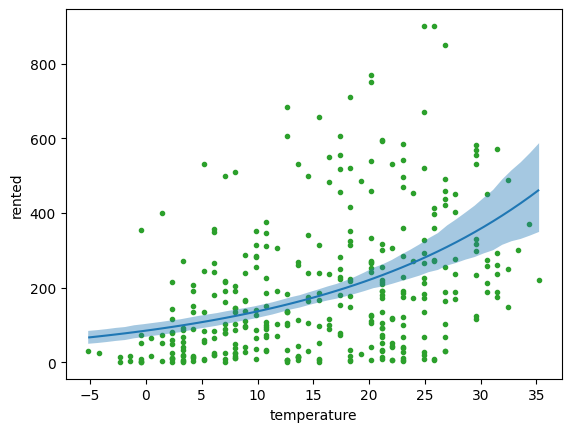

In [12]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

A final two lines give us the posterior predictive distribution.

In both graphs, the shaded blue area is a 94% HDI. You can change this by using the prob argument in the plot_predictions method.

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


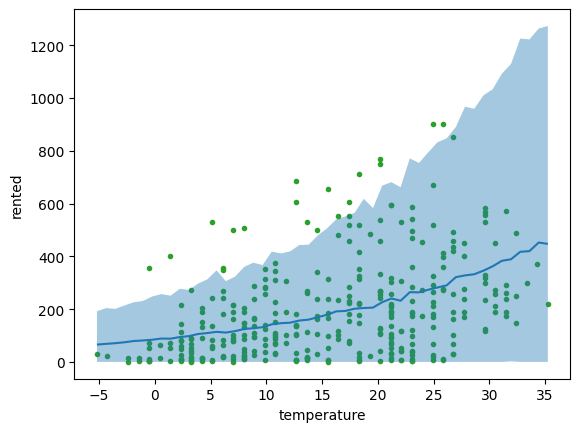

In [13]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature", pps=True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

#### Regularizing Priors (weakly informative priors)

We do not have to specify priors get a bambi model to run; bambi has a routine to determine the priors based off the raw data. Remember, that's the same strategy I told you to employ when you needed to specify prior(s) for which you had no context.

So, if you're handed data you know next to nothing about, you can safely selected a likelihood, and fire the model up.

But if you do have an understanding of the context, your final model should reflect your knowledge in its priors.

In [14]:
#notice that the priors argument isn't specified
model_nbb_bmb_regpriors = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial")
idata_nbb_bmb_regpriors = model_nbb_bmb_regpriors.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

If you do let bambi select priors for you, then you must print out the model, to see what it selected. That way, you can check if its selections jive with your inuition.

In [15]:
model_nbb_bmb_regpriors

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's see the posterior mean and posterior predictive.

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


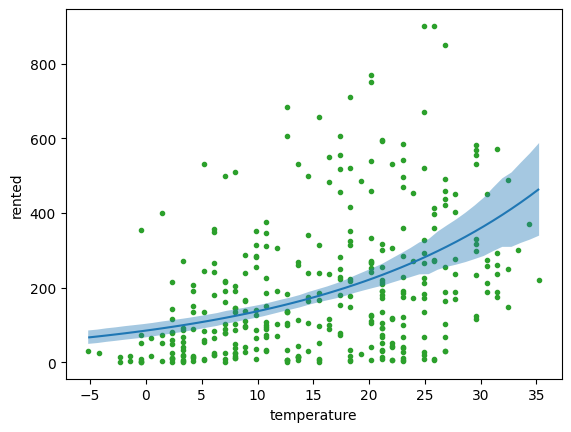

In [16]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


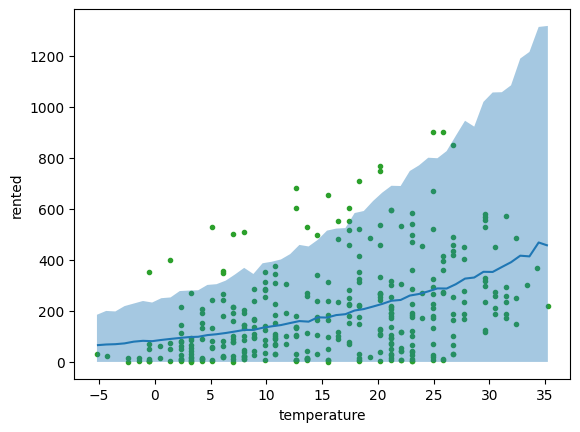

In [17]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature", pps = True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

**Task4**:

Are their any significant differences in the graphs of model_nbb_bmb and model_nbb_regpriors?

Why or why not?

**Answer4**:

No. The priors bambi selected were basically the same as the ones we chose, so it didn't make much of a difference.

#### Bambi bikes (multiple predictors)

Now that we know what a regularings prior is, and why they're often good enough let's recreate the model with both temperature and hour.

And since I was using the data to create my priors anyway, I let bambi choose my priors.

In [18]:
model_mlb_bmb = bmb.Model("rented ~ temperature + hour", bikes, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

I need to print the model, so I can see what priors bambi went with.

In [19]:
model_mlb_bmb

       Formula: rented ~ temperature + hour
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 6.4428)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
            hour ~ Normal(mu: 0.0, sigma: 0.3615)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's visualize the model, so we can actually see what it suggests.

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 24 Axes>,
 array([[<Axes: title={'center': 'hour = 0'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 1'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 2'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 3'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 4'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 5'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 6'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 7'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 8'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 9'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 10'}, xlabel='temperature', ylabel='rented'>,
         <Axes

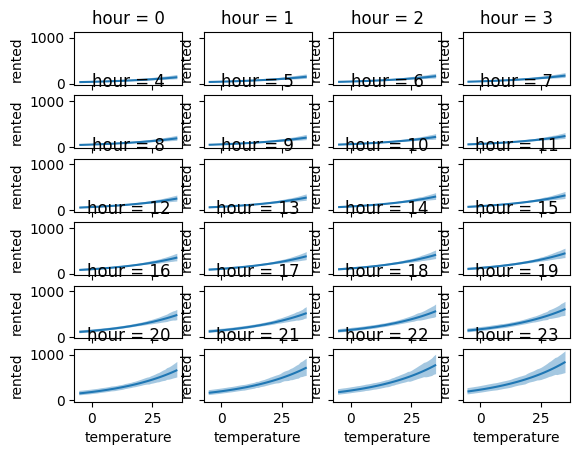

In [20]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["temperature", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

**Task5**:

Describe the relationship between the slope of temperature and the hour of the day, in model_mlb_bmb.

**Answer5**:

Larger hours of the day correspond to steeper slopes. Variance also increases.

Bambi models are equally compatible with arivz, since they are running pymc under the hood. These means everything we learned about elpd_loo still applies.

In [21]:
cmp_df_bmb = az.compare( {"multi_lin":idata_mlb_bmb,"single_lin":idata_nbb_bmb} )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2124.103780,4.447186,0.000000,0.931861,22.906637,0.000000,False,log
single_lin,1,-2153.010023,2.648577,28.906244,0.068139,19.519961,7.823392,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

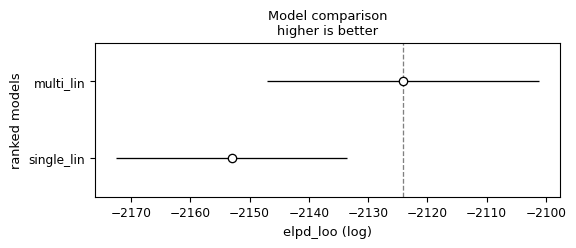

In [22]:
az.plot_compare(cmp_df_bmb)

## Underfiting versus Overfitting

When using multiple predictors, some logical questions arise:
- do we really need multiple predictors?
- if so, how many do we need?
- and which ones? Are some better than others? The same as others?

The process of answering those questions is known as variable selection.

**Task6**:

Given what you know and what we've learned thus far, how would you go about selecting which variables are best? If it helps, imagine we used all the variables in the bikes data set to predict rented.

**Answer6**:

[*write your answer here*]

I was going to use a library know as Kulprit to help us answer some questions about variable selection, but it is not ready yet.

Kulrit uses elpd_loo to automatically compare many variable combinations. It's main function is that it speeds things up; we can do the same thing by running models with different variable combinations ourselves.

**Task7**:

Try out different combinations of variables in the bikes data, to find the one that has the highest elpd_loo.

**Answer7**:

[*write your answer here*]

In [23]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


In [26]:
model_mlb_bmb_1 = bmb.Model("rented ~ temperature + weekday", bikes, family="negativebinomial")
idata_mlb_bmb_1 = model_mlb_bmb_1.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [27]:
model_mlb_bmb_2 = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
idata_mlb_bmb_2 = model_mlb_bmb_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [28]:
model_mlb_bmb_3 = bmb.Model("rented ~ temperature + windspeed", bikes, family="negativebinomial")
idata_mlb_bmb_3 = model_mlb_bmb_3.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [29]:
model_mlb_bmb_4 = bmb.Model("rented ~ humidity + windspeed", bikes, family="negativebinomial")
idata_mlb_bmb_4 = model_mlb_bmb_4.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [31]:
model_mlb_bmb_0 = bmb.Model("rented ~ temperature + hour", bikes, family="negativebinomial")
idata_mlb_bmb_0 = model_mlb_bmb_0.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [38]:
model_mlb_bmb_5 = bmb.Model("rented ~ temperature + hour + humidity + weekday", bikes, family="negativebinomial")
idata_mlb_bmb_5 = model_mlb_bmb_5.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [45]:
model_mlb_bmb_6 = bmb.Model("rented ~ temperature + hour + humidity + weekday + windspeed", bikes, family="negativebinomial")
idata_mlb_bmb_6 = model_mlb_bmb_6.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [46]:
model_mlb_bmb_7 = bmb.Model("rented ~ temperature + hour + weekday", bikes, family="negativebinomial")
idata_mlb_bmb_7 = model_mlb_bmb_7.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [47]:
cmp_df_bmb = az.compare( {"temp_hr":idata_mlb_bmb_0,"temp_wkday":idata_mlb_bmb_1,
                          "temp_hmd":idata_mlb_bmb_2,"temp_wndspd":idata_mlb_bmb_3,
                          "hmd_wndspd":idata_mlb_bmb_4,"temp_hr_hmd_wkday":idata_mlb_bmb_5,
                          "temp_hr_hmd_wkday_wndspd":idata_mlb_bmb_6, "temp_hr_wkday":idata_mlb_bmb_7}  )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
temp_hr_hmd_wkday,0,-2121.080232,6.301186,0.000000,0.803850,23.600600,0.000000,False,log
temp_hr_hmd_wkday_wndspd,1,-2121.257124,7.230253,0.176892,0.095266,23.463536,1.230198,False,log
temp_hr,2,-2124.145222,4.450672,3.064989,0.012783,22.913726,3.143707,False,log
temp_hr_wkday,3,-2124.794831,5.098220,3.714599,0.000000,22.930326,3.125801,False,log
temp_hmd,4,-2140.545993,3.812719,19.465761,0.000000,20.789483,6.458062,False,log
temp_wkday,5,-2153.835829,3.441429,32.755596,0.000000,19.496918,8.686434,False,log
temp_wndspd,6,-2153.868182,3.558413,32.787950,0.000000,19.532588,8.557724,False,log
hmd_wndspd,7,-2161.798281,3.172163,40.718049,0.088101,19.608942,9.630553,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

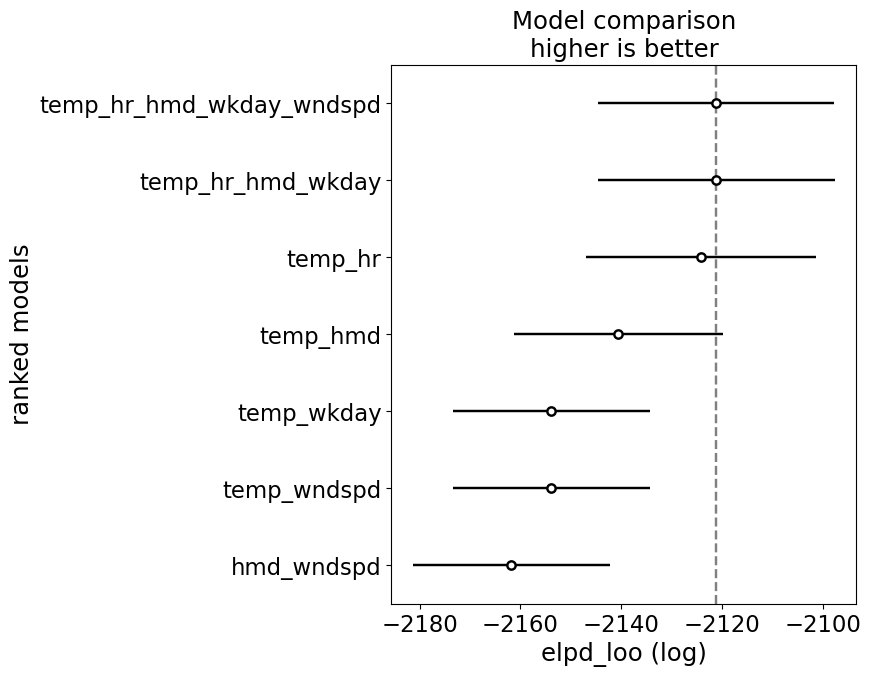

In [43]:
az.plot_compare(cmp_df_bmb)

You may find that the previous task feels dauting, or tedious. How do we know which variable combinations to try?

The answer is to draw something called a casual directed acyclic graph (DAG), or casual diagram.

Casual diagrams help us define our assumptions about the casual relationships between variables. This in turn helps us define what variables are important to include and exclude from a model.

**Task8**:

Your task is to come ask me for an example of a casual DAG (I ran out of time to make a walk through of casual diagrams.)

I will give you further instructions when you talk to me.
Those instructions have to do with the data below.

In [48]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [49]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

In [52]:
model_body_1 = bmb.Model("siri ~ weight + height + abdomen + thigh", body)
idata_body_1 = model_body_1.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [53]:
model_body_1

       Formula: siri ~ weight + height + abdomen + thigh
        Family: gaussian
          Link: mu = identity
  Observations: 251
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 19.0869, sigma: 653.6297)
            weight ~ Normal(mu: 0.0, sigma: 1.6936)
            height ~ Normal(mu: 0.0, sigma: 3.1202)
            abdomen ~ Normal(mu: 0.0, sigma: 2.0371)
            thigh ~ Normal(mu: 0.0, sigma: 4.2)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 8.307)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [55]:
model_body_2 = bmb.Model("siri ~ weight + height", body)
idata_body_2 = model_body_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [56]:
model_body_3 = bmb.Model("siri ~ weight + height + abdomen + thigh + wrist", body)
idata_body_3 = model_body_3.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [58]:
model_body_4 = bmb.Model("siri ~ abdomen + thigh + wrist", body)
idata_body_4 = model_body_4.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [60]:
model_body_5 = bmb.Model("siri ~ weight + height + wrist", body)
idata_body_5 = model_body_5.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [62]:
model_body_6 = bmb.Model("siri ~ weight +height + abdomen + thigh + wrist + age", body)
idata_body_6 = model_body_6.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [63]:
cmp_df_bmb = az.compare( {"wgt_hgt_abd_thg":idata_body_1,"wgt_hgt":idata_body_2,
                          "wgt_hgt_abd_thg_wrs":idata_body_3,"abd_thg_wrs":idata_body_4,
                          "wgt_hgt_wrs":idata_body_5,"wgt_hgt_abd_thg_wrs_age":idata_body_6}  )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
wgt_hgt_abd_thg_wrs_age,0,-724.057411,7.176137,0.000000,0.801576,9.430894,0.000000,False,log
wgt_hgt_abd_thg_wrs,1,-725.466924,6.313866,1.409513,0.000000,9.293059,2.006079,False,log
wgt_hgt_abd_thg,2,-729.543542,5.797050,5.486131,0.098726,9.401875,3.762101,False,log
abd_thg_wrs,3,-731.537836,4.423337,7.480425,0.099698,9.505906,4.307016,False,log
wgt_hgt_wrs,4,-787.279387,4.962077,63.221976,0.000000,10.025092,9.573656,False,log
wgt_hgt,5,-792.316570,3.943860,68.259159,0.000000,9.612631,9.692356,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

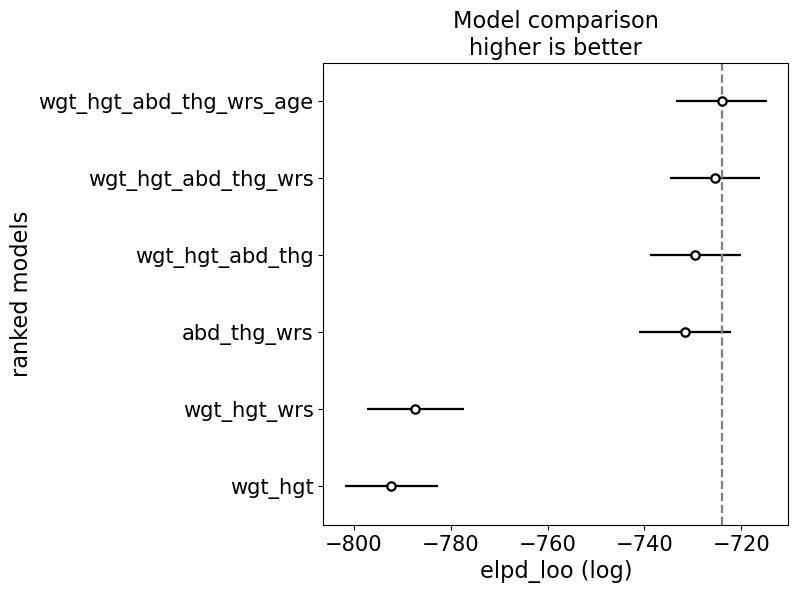

In [64]:
az.plot_compare(cmp_df_bmb)

### Things to Know about Under and Over fitting:

We pick the first submodel whose mean elpd_loo value is also inside the shaded HDI of the reference model. Remember, the reference model is the one with all avaiable variables.

When we aren't confident in our casual model:

- selecting a model based on elpd_loo ensures we are doing our best to account for underfitting, or trying our best to be accurate.
- selecting a model with the smallest number of variables ensures we are doing our best to avoid overfitting, or letting our model get distriacted by unneccesary information.

Technically, the regulizing priors that bambi selected based on the data go a long way to making sure our predictions won't be too bad on new data, even if we include an extra few variables.

I'll say that again: weakly informative, or regularizing, priors do a lot to prevent overfitting. Priors are pretty much *the* way to help prevent overfitting.

In fact, having a bias towards models with less variables can itself be constructed as a prior. We're not going to make our preference that explicit, but the point is that we could.

The reason we won't make it that explicit, is that we want variable selection to be fluid. If we think an extra variable or two could capture information that happened to not be in this data set, then by all means, use your contextual knowledge to selcect a model with more variables.

This is especially true if our casual model includes lots of variables, and we our confident in our casual model.

However,f we know that collecting data on more variables is expensive or dangerous, then we can select a smaller model.

Variable selection,is complicated. You must draw a casual diagram, calculate elpd_loo, compare to another model, adjust accordingly and then repeat that process until you end up with something you believe in.

**Answer8**:

[*write your answer here*]

## Distributional models: Dealing with variable variance

We'll now take a quite detour back to single predictor land, so that I can show you how to account for variable variance with bambi.

When we build a linear regression model, there is at least one linear equation applied in our formulas--usually to the location/center parameter of our likelihood, which we've been calling mu.

Applying a linear equation to more than one parameter of our likelihood is called a distributional model. We've done this before with the babies dataset. We'll do it again now, but use bambi.


In [6]:
babies = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/babies.csv")

In [7]:
#we need to specify the two regression relationships with a bambi method
formula_babies = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)

#dis for distributional model
model_dis = bmb.Model(formula_babies, babies)

#I only need "idata_kwargs={"log_likelihood":True}"" if I'm going to use
#elpd_loo for variable selection. So I could have dropped it here
idata_dis = model_dis.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [8]:
#shows me what priors/likelihood bambi used.
model_dis

       Formula: length ~ np.sqrt(month)
                sigma ~ month
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 796
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 72.5125, sigma: 72.0827)
            np.sqrt(month) ~ Normal(mu: 0.0, sigma: 21.3849)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_month ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


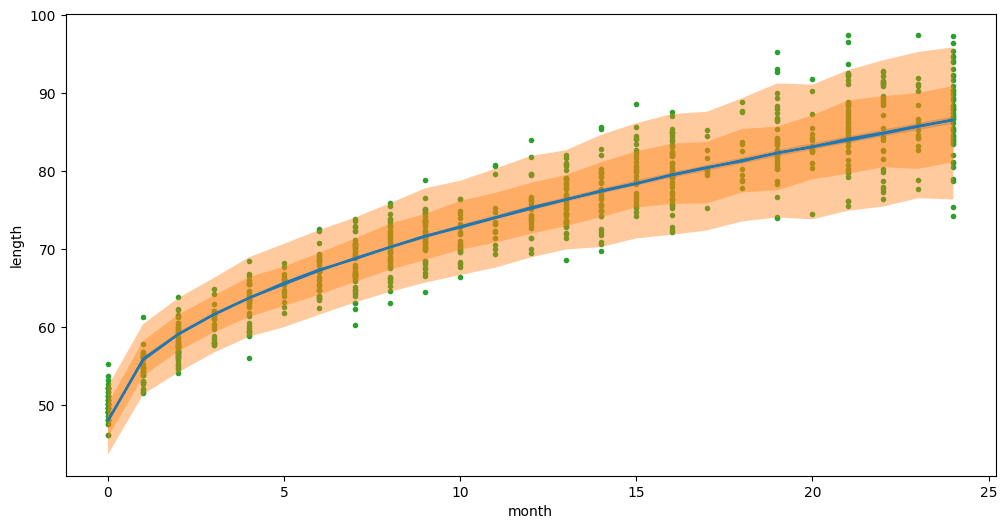

In [9]:
#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(babies.month, babies.length, "C2.", zorder=-3)

Same thing as in the previous unit. Neat.

## Categorical variables, Hierarchies, and Interactions

With the basics of multiple linear regression and bambi behind us, we can now look at the various ways variables can intereact. A tad onfusingly, only one of these methods is called an interaction.

We'll recreate:
- see how categorical variables work with multiple linear regression
- examine hierearchies through bambi
- introduce interactions, in light of categorical variables and hierarchies.

Note: all priors will be regularizing priors, or weakly informative priors, that bambi will select based on the data itself.




### Categorical variables versus Hierarchies

Let's get back to the action something new: creating a model with categorical variables and quantitative variables. Sepcifically, one categorical and several quantitative variables.

We'll also create a hierarchical regression with that same categorical variable, and discuss when to treat it as its own variable, and when to think of it as a hierarchy.

In [10]:
#have to drop incomplete rows, so that bambi will run
basketball = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv').dropna()

In [11]:
#only look at players who played more than 400 minutes
basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
basketball = basketball.query('`FT%` != 1.0')

In [12]:
#filter out the combo positions. This while make it easier to read the graphs
basketball = basketball.query("Pos in ['C','PF','SF','SG','PG']")

In [13]:
#define the model
model_basketball = bmb.Model("`FG%` ~ `FT%` + Pos", data=basketball)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

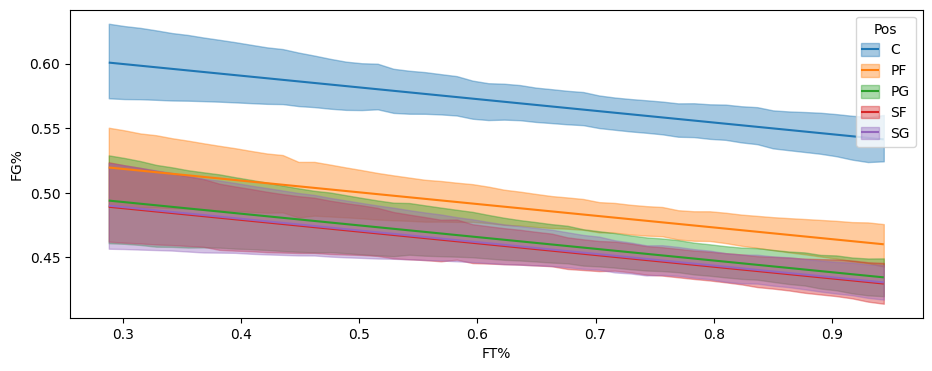

In [14]:
#plot 94% HDIs of the means of each position
bmb.interpret.plot_predictions(model_basketball,
                               idata_basketball,
                                ["FT%",  "Pos"], fig_kwargs={"figsize":(11, 4)})

Before explaining what's going on, I'm goin to jump right in the using Pos as a hierarchy.

In [15]:
#define the model, but as a hierarchy
model_basketball_h = bmb.Model("`FG%` ~ (`FT%`|Pos)", data=basketball)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

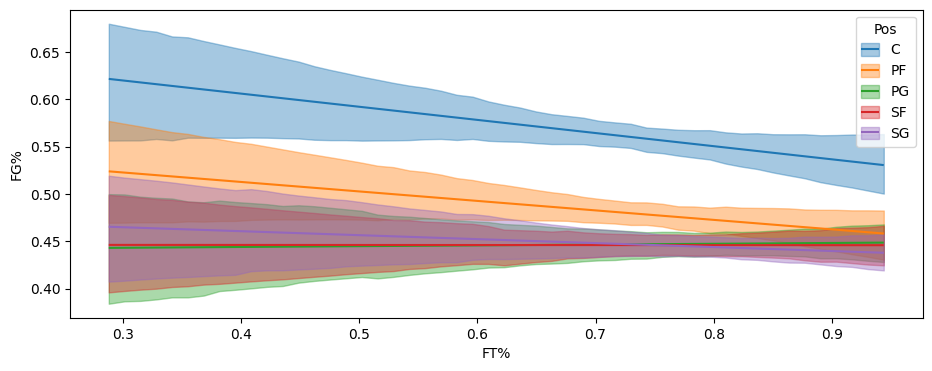

In [16]:
bmb.interpret.plot_predictions(model_basketball_h,
                               idata_basketball_h,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

**Task9**:

Identify and explain any similarities or differences in the plots of model_basketball and model_basketball_h.

**Answer9**:

[*write your answer here*]

#### Interactions

It's often the case that the effect of a predictor on the respone variable is affected by a different predictor variable.

I'll continue to use the basketball data set for this, and I'll use one example with a categorical/quantitative variable combo, and one with two quantitative variables.

In [17]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`FG%` ~ `FT%` + Pos + `FT%`:Pos", data=basketball)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

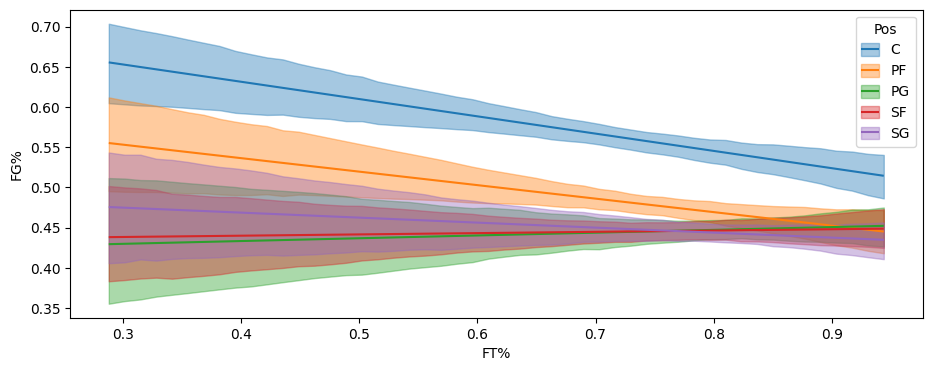

In [18]:
bmb.interpret.plot_predictions(model_bb_inter,
                               idata_bb_inter,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

**Task10**:

Compare this with the previous two graphs. How has the interaction affected the slope of FT% with respect to FG%?

**Answer10**:

[*write your answer here*]

Let's do an interaction effect with all quantiative variables. For this model, I'll just replace Pos with 3PA.

In [19]:
#define the model; bb_interq stands for baskeball interaction quantiative
model_bb_interq = bmb.Model("`FG%` ~ `FT%` + `3PA` + `FT%`:`3PA`", data=basketball)
#create the model
idata_bb_interq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

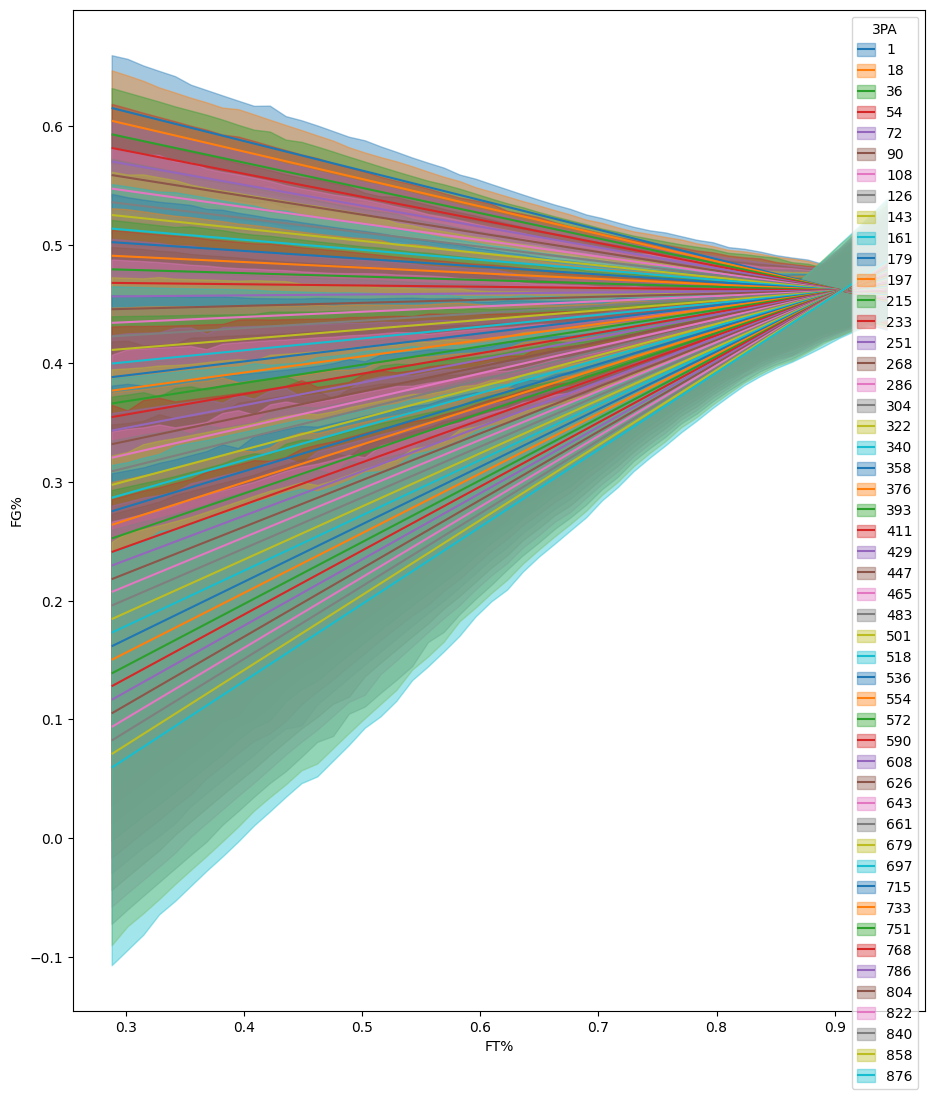

In [20]:
bmb.interpret.plot_predictions(model_bb_interq,
                               idata_bb_interq,
                               ["FT%","3PA"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

**Task11**:

Using the plot above, describe the effect of 3PA on slope of FT% with respect to FG%.

**Answer11**:

[*write your answer here*]

**Task12**:

Using the visualizations of model_bb_inter and model_bb_interq, answer the following:
1. Do centers (C) have, on average, low 3PA compared to other positions?
2. Is FT% a good predictor of FG%?

**Answer12**:

[*write your answer here*]

## Summary

As usual, we've covered a lot of ground in one unit.

We:

- learned how to use multiple predictors at once, both in vanilla pymc and using a new library, bambi.
- saw that having multiple predictors made model selection much more challenging, and we practiced using a new metric--elpd_loo--to help us decide between models
- further complicated model selection with variable selection, and the notion of Under/Overfitting. We learned that:
  - our priors have been helping with overfitting all along,
  - elpd_loo helps pick a model that doesn't underfit too much.
  - we should have a bias towards simpler models, to further guard agaisnt overfitting, and to help make our models more interpretable.
- Practiced comparing and contrasting the predictions and fit of categorical varibles, hierarchies, and interactions.

And now I say, congradulations! You have almost all the basics of generalized linear models at your disposal now. This is a big deal; GLMs are often a good approximation of many processes, and they are often interpretable. There's plenty more to learn, but the paths in front of you have now become much more varied.

In the next unit, we'll cover the reamining basics of glms (polynomial regression, b splines) in order to give you inuition for the most powerful modeling tool of all, a tool from which nerual networks are but one instance of: Gaussian Processes.